In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.optimize import brute, fmin, minimize
from scipy.stats import norm
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

#Using the data from stochastic modelling course for market calibration
# Market Data from www.eurexchange.com
# as of September 30, 2014

data = pd.read_csv("data.csv")
S0 = 3225.93  # EURO STOXX 50 level September 30, 2014

In [3]:
# Option Selection - We will select nearly ATM options

tol = 0.02  # Tolerance level to select ATM options (percent around ITM/OTM options)
options = data[(np.abs(data["Strike"] - S0) / S0) < tol]
options["Date"] = pd.DatetimeIndex(options["Date"])
options["Maturity"] = pd.DatetimeIndex(options["Maturity"])

# Then, we add time left until maturity and a constant risk-free rate:
# Adding Time-to-Maturity and constant short-rates

for row, option in options.iterrows():
    T = (option["Maturity"] - option["Date"]).days / 365.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 0.005  # ECB base rate

In [4]:
options.head()

,Date,Strike,Call,Maturity,Put,T,r
38,2014-09-30,3175.0,126.8,2014-12-19,78.8,0.219178,0.005
39,2014-09-30,3200.0,110.9,2014-12-19,87.9,0.219178,0.005
40,2014-09-30,3225.0,96.1,2014-12-19,98.1,0.219178,0.005
41,2014-09-30,3250.0,82.3,2014-12-19,109.3,0.219178,0.005
42,2014-09-30,3275.0,69.6,2014-12-19,121.6,0.219178,0.005


### BS BM Market Calibration

In [5]:
i = 0
min_RMSE = 100

In [6]:
def BS_BM_call_value(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.

    Parameters:
    S (float): Spot price of the underlying asset
    K (float): Strike price of the option
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annualized)
    sigma (float): Volatility of the underlying asset (annualized)

    Returns:
    float: Black-Scholes call option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [7]:
def BS_BM_error_function(p0):
    """
    Error function for parameter calibration in BS-BM model
    ---------------
    Parameters to calibrate:
    sigma: float
           volatility factor in diffusion term
     ----------------
    RMSE: Root Mean Squared Error
    """
    global i, min_RMSE
    sigma = p0

    if sigma < 0.0:
        return 500.0
    se = []

    for row, option in options.iterrows():
        model_value = BS_BM_call_value(S0, option["Strike"], option["T"], option["r"], sigma)
        se.append((model_value - option["Call"]) ** 2)

    RMSE = np.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (RMSE, min_RMSE))
    i += 1
    return RMSE

In [8]:
def BS_BM_calibration_full():
    """
    Calibrates BS BM option model to market quotes
    """
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        BS_BM_error_function,
        (
            (0.075, 1.0, 0.025),  # sigma
        ),  
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(BS_BM_error_function, p0, xtol=0.0001, ftol=0.0001, maxiter=550, maxfun=1050)
    return opt

In [9]:
opt = BS_BM_calibration_full()

   0 | [0.075] |  51.327 |  51.327
  50 | [0.15714844] |   3.605 |   3.605
Optimization terminated successfully.
         Current function value: 3.604536
         Iterations: 8
         Function evaluations: 16


In [10]:
#Generate BS Mprices
for row, option in options.iterrows():
        options.loc[row, "BS_BM_Model"] = BS_BM_call_value(S0, option["Strike"], option["T"], option["r"], opt)

### BS FBM Market Calibration

In [11]:
# Fractional Black-Scholes Model (FBM)
def BS_FBM_call_value(S, K, T, r, sigma, H):
    sigma_fbm = sigma * T**(H - 0.5)  # Adjusted volatility under FBM
    d1 = (np.log(S / K) + (r + 0.5 * sigma_fbm**2) * T) / (sigma_fbm * np.sqrt(T))
    d2 = d1 - sigma_fbm * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [12]:
i = 0
min_RMSE = 100

In [13]:
def BS_FBM_error_function(p0):
    """
    Error function for parameter calibration in BS-FBM model
    ---------------
    Parameters to calibrate:
    sigma: float
           volatility factor in diffusion term
    H: float
       Hurst Component
    ----------------
    RMSE: Root Mean Squared Error
    """
    global i, min_RMSE
    sigma, H = p0

    if sigma < 0.0 or H < 0.0 or H > 1.0:
        return 500.0
    se = []

    for row, option in options.iterrows():
        model_value = BS_FBM_call_value(S0, option["Strike"], option["T"], option["r"], sigma, H)
        se.append((model_value - option["Call"]) ** 2)

    RMSE = np.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (RMSE, min_RMSE))
    i += 1
    return RMSE

In [14]:
def BS_FBM_calibration_full():
    """
    Calibrates BS FBM option model to market quotes
    """
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        BS_FBM_error_function,
        (
            (0.1, 1.0, 0.025),  # sigma (Sigma from BS BM - 0.15720703)
            (0.0, 1.0, 0.01),  # Hurst

        ),  
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(BS_FBM_error_function, p0, xtol=0.0001, ftol=0.0001, maxiter=550, maxfun=1050)
    return opt

In [15]:
opt = BS_FBM_calibration_full()

   0 | [0.1 0. ] |  50.461 |  50.461
  50 | [0.1 0.5] |  35.986 |  19.507
 100 | [0.125 0.   ] |  76.177 |  19.507
 150 | [0.125 0.5  ] |  20.542 |   9.683
 200 | [0.15 0.  ] | 105.381 |   9.683
 250 | [0.15 0.5 ] |   5.803 |   3.216
 300 | [0.175 0.   ] | 135.835 |   3.216
 350 | [0.175 0.5  ] |  11.748 |   3.216
 400 | [0.2 0. ] | 166.841 |   3.216
 450 | [0.2 0.5] |  27.181 |   3.216
 500 | [0.225 0.   ] | 198.121 |   3.216
 550 | [0.225 0.5  ] |  42.870 |   3.216
 600 | [0.25 0.  ] | 229.542 |   3.216
 650 | [0.25 0.5 ] |  58.615 |   3.216
 700 | [0.275 0.   ] | 261.034 |   3.216
 750 | [0.275 0.5  ] |  74.382 |   3.216
 800 | [0.3 0. ] | 292.553 |   3.216
 850 | [0.3 0.5] |  90.158 |   3.216
 900 | [0.325 0.   ] | 324.070 |   3.216
 950 | [0.325 0.5  ] | 105.934 |   3.216
1000 | [0.35 0.  ] | 355.566 |   3.216
1050 | [0.35 0.5 ] | 121.707 |   3.216
1100 | [0.375 0.   ] | 387.024 |   3.216
1150 | [0.375 0.5  ] | 137.474 |   3.216
1200 | [0.4 0. ] | 418.434 |   3.216
1250 | [0.4 0.5

In [16]:
#Generate BS FBM prices
sigma, H = opt
for row, option in options.iterrows():
        options.loc[row, "BS_FBM_Model"] = BS_FBM_call_value(S0, option["Strike"], option["T"], option["r"], sigma, H)

### BS MBM Market Calibration - Deterministic Hurst

In [17]:
X = options[["T", "Strike", "r"]].values
y = options["Call"].values

# Multifractional Black-Scholes Call Pricing Function
def mbm_call_value(S, K, T, r, sigma, params, function_type="sinusoidal"):
    """
    Multifractional Black-Scholes Call Pricing Function with multiple H(t) forms.
    S: Spot price
    K: Strike price
    T: Time to maturity
    r: Risk-free rate
    sigma: Volatility
    params: Parameters for the time-dependent H(t)
    function_type: Type of H(t) function (sinusoidal, exponential, logarithmic, polynomial, sigmoid, oscillatory, linear)
    wavelet_H: Wavelet-based dynamic Hurst values (optional)
    """
    A, B, C = params

    # Define H_t based on the chosen function type
    if function_type == "sinusoidal":
        H_t = A * np.cos(2 * np.pi * (252 / 30) * T + B) + C
    elif function_type == "exponential":
        H_t = A * np.exp(-B * T) + C
    elif function_type == "logarithmic":
        H_t = A * np.log(T + 1) + C
    elif function_type == "polynomial":
        H_t = A * T**B + C
    elif function_type == "sigmoid":
        H_t = A / (1 + np.exp(-B * (T - C)))
    elif function_type == "oscillatory":
        H_t = A * np.cos(2 * np.pi * (252 / 30) * T + B) * np.exp(-C * T)
    elif function_type == "linear":
        H_t = A * T + B
    else:
        raise ValueError("Invalid function type specified for H(t).")

    # Ensure H_t stays within valid bounds (0.01, 0.99)
    H_t = np.clip(H_t, 0.01, 0.99)

    # Adjust volatility based on H_t
    sigma_mbm = sigma * T ** (H_t - 0.5)

    # Black-Scholes calculations
    d1 = (np.log(S / K) + (r + 0.5 * sigma_mbm**2) * T) / (sigma_mbm * np.sqrt(T))
    d2 = d1 - sigma_mbm * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Error Function to Minimize
def mbm_error(params, S, K, T, r, y_true, function_type="sinusoidal"):
    """
    Error function to calculate RMSE between model and market prices.
    params: [sigma, A, B, C]
    function_type: Type of H(t) function
    """
    sigma = params[0]
    H_params = params[1:]
    
    if sigma <= 0 or not (0 < H_params[2] < 1):  # Ensure valid H(t)
        return 1e6  # Penalize invalid values

    # Model prices
    model_prices = mbm_call_value(S, K, T, r, sigma, H_params, function_type)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, model_prices))
    return rmse

# Optimization Function
def optimize_mbm(S, K, T, r, y, function_type="sinusoidal"):
    """
    Optimizes the MBS parameters for a given H(t) function type.
    """
    # Initial guesses for [sigma, A, B, C]
    initial_guess = [0.2, 0.1, 0, 0.5]

    # Bounds for [sigma, A, B, C]
    bounds = [(0.01, 1.0),  # sigma
              (-1.0, 1.0),  # A (amplitude)
              (-np.pi, np.pi),  # B (phase shift)
              (0.01, 0.99)]  # C (offset)

    # Perform optimization
    result = minimize(mbm_error, initial_guess, args=(S, K, T, r, y, function_type), bounds=bounds, method='L-BFGS-B')

    return result

# Spot price
S = 3225.93  # Replace with actual spot price
K = X[:, 1]  # Strike prices
T = X[:, 0]  # Time to maturities
r = X[:, 2]  # Risk-free rates

# Test Different H(t) Functions
functions = ["sinusoidal", "exponential", "logarithmic", "polynomial", "sigmoid", "oscillatory", "linear"]
results = {}

for func in functions:
    result = optimize_mbm(S, K, T, r, y, func)
    results[func] = {
        "params": result.x,
        "rmse": mbm_error(result.x, S, K, T, r, y, func)
    }
    print(f"Function: {func}")
    print(f"Optimized Parameters: {result.x}")
    print(f"Optimized RMSE: {results[func]['rmse']}")

# Summary
print("\nSummary of Results:")
for func, res in results.items():
    print(f"Function: {func}, RMSE: {res['rmse']}, Parameters: {res['params']}")

Function: sinusoidal
Optimized Parameters: [ 0.16049452  0.03337681 -0.05421836  0.50283059]
Optimized RMSE: 2.793256951769039
Function: exponential
Optimized Parameters: [ 0.15383952 -0.44159826  0.0867379   0.91186496]
Optimized RMSE: 3.118848127455165
Function: logarithmic
Optimized Parameters: [0.18552582 0.58600483 0.         0.49871366]
Optimized RMSE: 2.7932569520887935
Function: polynomial
Optimized Parameters: [0.163946   0.32743656 0.12734963 0.26349477]
Optimized RMSE: 2.7932569519370287
Function: sigmoid
Optimized Parameters: [ 0.14173494  0.47838396 -3.14159265  0.88383872]
Optimized RMSE: 3.0689419465053596
Function: oscillatory
Optimized Parameters: [0.09428943 1.         2.48608831 0.01      ]
Optimized RMSE: 14.527296469504758
Function: linear
Optimized Parameters: [0.24787794 1.         3.14159265 0.5       ]
Optimized RMSE: 22.456626523672114

Summary of Results:
Function: sinusoidal, RMSE: 2.793256951769039, Parameters: [ 0.16049452  0.03337681 -0.05421836  0.502830

In [18]:
for func, res in results.items():
    for row, option in options.iterrows():
        col_name = f"BS_MBM_{func}"
        options.loc[row, col_name] = mbm_call_value(S0, option["Strike"], option["T"], option["r"], res['params'][0], res['params'][1:],func)

### BS MBM Market Calibration - Stochastic Hurst

In [19]:
X = options[["T", "Strike", "r"]].values
y = options["Call"].values

# Simulate Stochastic H(t) as an OU Process
def simulate_H(T, theta, mu, sigma_H, H0=0.5, dt=0.0001):
    """
    Simulate stochastic H(t) using the Ornstein-Uhlenbeck process.
    T: Time to maturity
    theta: Speed of mean reversion
    mu: Long-term mean of H
    sigma_H: Volatility of H
    H0: Initial value of H
    dt: Time step
    """
    steps = int(T / dt)
    H = np.zeros(steps + 1)
    H[0] = H0
    for t in range(steps):
        dW = np.random.normal(0, np.sqrt(dt))
        H[t + 1] = H[t] + theta * (mu - H[t]) * dt + sigma_H * dW
    return H[-1]  # Return the final value of H(t)

# Multifractional FBM Option Pricing Function
def mbm_call_value(S, K, T, r, sigma, params, theta, mu, sigma_H):
    """
    Multifractional Black-Scholes Call Pricing Function.
    S: Spot price
    K: Strike price
    T: Time to maturity
    r: Risk-free rate
    sigma: Volatility
    params: Parameters for stochastic H(t) [theta, mu, sigma_H]
    """
    # Simulate H(t) for each maturity
    H_t = np.array([simulate_H(t, theta, mu, sigma_H) for t in T])

    # Ensure H_t stays in (0, 1)
    H_t = np.clip(H_t, 0.01, 0.99)

    sigma_mbm = sigma * T ** (H_t - 0.5)
    d1 = (np.log(S / K) + (r + 0.5 * sigma_mbm**2) * T) / (sigma_mbm * np.sqrt(T))
    d2 = d1 - sigma_mbm * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


# Error Function to Minimize
def mbm_error(params, S, K, T, r, y_true):
    """
    Error function to calculate RMSE between model and market prices.
    params: [sigma, theta, mu, sigma_H]
    """
    sigma = params[0]
    theta = params[1]
    mu = params[2]
    sigma_H = params[3]
    
    if sigma <= 0 or not (0 < mu < 1):  # Ensure valid H(t)
        return 1e6  # Penalize invalid values

    # Model prices
    model_prices = mbm_call_value(S, K, T, r, sigma, params, theta, mu, sigma_H)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, model_prices))
    return rmse

# Optimization Setup
S = 3225.93  # Spot price
K = X[:, 1]  # Strike prices
T = X[:, 0]  # Time to maturities
r = X[:, 2]  # Risk-free rates

# Initial guesses for [sigma, theta, mu, sigma_H]
initial_guess = [0.2, 0.5, 0.5, 0.1]

# Bounds for [sigma, theta, mu, sigma_H]
bounds = [(0.01, 1.0),  # sigma
          (0.1, 1.0),   # theta (speed of reversion)
          (0.01, 0.99), # mu (mean of H)
          (0.01, 0.5)]  # sigma_H (volatility of H)

# Perform optimization
result = minimize(mbm_error, initial_guess, args=(S, K, T, r, y), bounds=bounds, method='L-BFGS-B')

# Extract optimized parameters
optimized_sigma = result.x[0]
optimized_theta = result.x[1]
optimized_mu = result.x[2]
optimized_sigma_H = result.x[3]

print("Optimized Sigma:", optimized_sigma)
print("Optimized Theta (Speed of Reversion):", optimized_theta)
print("Optimized Mu (Long-Term Mean):", optimized_mu)
print("Optimized Sigma_H (Volatility of H):", optimized_sigma_H)

# Calculate RMSE for the optimized parameters
optimized_rmse = mbm_error(result.x, S, K, T, r, y)
print("Optimized RMSE:", optimized_rmse)

def predict_mbm_prices(dataframe, S, r, params):
    """
    Predict option prices using the calibrated MBM model with deterministic H(t).
    
    Parameters:
    - dataframe: DataFrame containing columns ["T", "Strike"] for prediction.
    - S: Spot price.
    - r: Risk-free rate.
    - params: Optimized parameters [sigma, theta, mu, sigma_H].
    
    Returns:
    - DataFrame with predicted prices.
    """
    sigma, theta, mu, sigma_H = params
    T = dataframe["T"].values
    K = dataframe["Strike"].values

    # Compute H(t) deterministically
    H_0 = 0.5  # Initial value of H
    H_t = mu + (H_0 - mu) * np.exp(-theta * T)

    # Ensure H_t stays within valid bounds (0.01, 0.99)
    H_t = np.clip(H_t, 0.01, 0.99)

    # Compute sigma_mbm
    sigma_mbm = sigma * T ** (H_t - 0.5)

    # Compute option prices using the Black-Scholes formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma_mbm**2) * T) / (sigma_mbm * np.sqrt(T))
    d2 = d1 - sigma_mbm * np.sqrt(T)
    predicted_prices = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    # Add predicted prices to the DataFrame
    dataframe["BS_MBM_Stochastic_H"] = predicted_prices
    return dataframe

Optimized Sigma: 0.2000035702858324
Optimized Theta (Speed of Reversion): 0.49999798763856834
Optimized Mu (Long-Term Mean): 0.5000021577872168
Optimized Sigma_H (Volatility of H): 0.09999930728779408
Optimized RMSE: 29.189660644139657


In [20]:
params = [optimized_sigma, optimized_theta, optimized_mu, optimized_sigma_H]
predicted_df = predict_mbm_prices(options, S, r, params)

In [21]:
# View predictions
predicted_df

,Date,Strike,Call,Maturity,Put,T,r,BS_BM_Model,BS_FBM_Model,BS_MBM_sinusoidal,BS_MBM_exponential,BS_MBM_logarithmic,BS_MBM_polynomial,BS_MBM_sigmoid,BS_MBM_oscillatory,BS_MBM_linear,BS_MBM_Stochastic_H
38,2014-09-30,3175.0,126.8,2014-12-19,78.8,0.219178,0.005,123.597874,124.686858,122.807234,124.595495,122.807282,122.807233,124.448890,135.487871,100.904424,148.611790
39,2014-09-30,3200.0,110.9,2014-12-19,87.9,0.219178,0.005,109.712533,110.826463,108.903467,110.733026,108.903517,108.903466,110.583086,121.851155,86.346878,135.201503
40,2014-09-30,3225.0,96.1,2014-12-19,98.1,0.219178,0.005,96.879672,98.006352,96.061219,97.911853,96.061269,96.061218,97.760206,109.147642,73.184550,122.620897
41,2014-09-30,3250.0,82.3,2014-12-19,109.3,0.219178,0.005,85.095022,86.222121,84.276324,86.127583,84.276374,84.276323,85.975875,97.372020,61.420029,110.864209
42,2014-09-30,3275.0,69.6,2014-12-19,121.6,0.219178,0.005,74.342908,75.458363,73.532907,75.364787,73.532957,73.532906,75.214629,86.511101,51.028687,99.920200
102,2014-09-30,3175.0,171.0,2015-03-20,129.2,0.468493,0.005,168.308465,166.873002,167.752962,166.638595,167.752953,167.752994,166.987854,150.737926,180.132510,205.175005
103,2014-09-30,3200.0,156.1,2015-03-20,139.4,0.468493,0.005,155.048985,153.593668,154.485835,153.355990,154.485826,154.485868,153.710120,137.211359,167.025958,192.343921
104,2014-09-30,3225.0,142.0,2015-03-20,150.3,0.468493,0.005,142.510961,141.043483,141.943122,140.803806,141.943112,141.943154,141.160913,124.513303,154.583193,180.080521
105,2014-09-30,3250.0,128.5,2015-03-20,161.8,0.468493,0.005,130.689164,129.217230,130.119598,128.976828,130.119588,130.119630,129.335016,112.638921,142.798957,168.379745
106,2014-09-30,3275.0,115.8,2015-03-20,174.0,0.468493,0.005,119.574780,118.105988,119.006407,117.866117,119.006398,119.006440,118.223516,101.577864,131.665226,157.234840


### Calculating RMSE across all methods

In [22]:
def calculate_rmse(dataframe, market_price_column, method_columns):
    """
    Calculate RMSE for multiple methods compared to the real market price.

    Parameters:
    - dataframe: The DataFrame containing the market price and estimated prices.
    - market_price_column: Column name of the real market price.
    - method_columns: List of column names for estimated prices by different methods.

    Returns:
    - A dictionary with method names as keys and their corresponding RMSE values.
    """
    rmse_results = {}

    for method in method_columns:
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(dataframe[market_price_column], dataframe[method]))
        rmse_results[method] = rmse

    return rmse_results


# Example usage
# Replace 'Real_Market_Price' with your actual market price column
# Replace ['Method1', 'Method2', 'Method3'] with your actual method columns
real_market_price_column = "Call"  # Column containing actual market prices
estimated_price_columns = ["BS_BM_Model", "BS_FBM_Model", "BS_MBM_sinusoidal", "BS_MBM_exponential", "BS_MBM_logarithmic", "BS_MBM_polynomial", "BS_MBM_sigmoid", "BS_MBM_oscillatory", "BS_MBM_linear", "BS_MBM_Stochastic_H"]  # Columns for different methods

# Calculate RMSE for all methods
rmse_results = calculate_rmse(predicted_df, real_market_price_column, estimated_price_columns)

# Print the RMSE results
for method, rmse in rmse_results.items():
    print(f"Method: {method}, RMSE: {rmse}")

Method: BS_BM_Model, RMSE: 3.6045361710758956
Method: BS_FBM_Model, RMSE: 3.147615769934396
Method: BS_MBM_sinusoidal, RMSE: 2.793256951769039
Method: BS_MBM_exponential, RMSE: 3.118848127455165
Method: BS_MBM_logarithmic, RMSE: 2.7932569520887935
Method: BS_MBM_polynomial, RMSE: 2.7932569519370287
Method: BS_MBM_sigmoid, RMSE: 3.0689419465053596
Method: BS_MBM_oscillatory, RMSE: 14.527296469504758
Method: BS_MBM_linear, RMSE: 22.456626523672114
Method: BS_MBM_Stochastic_H, RMSE: 27.18284248190176


### **Options expiring on 21 Jan 2025**

The call option price `^SPX` is collected from the Polygon.io and the option contracts are listed on Yahoo Finance.

In [76]:
import yfinance as yf


options_data = pd.read_csv("spx_opt_2025_1_21_prices.csv").set_index("Date")

options_data.index = pd.to_datetime(options_data.index, format="%Y-%m-%d")
options_data = options_data.sort_index(ascending=True)

options_data = options_data.loc[:, ~options_data.iloc[0].isna()]


options_data.dropna(how='all', inplace=True)
options_data.dropna(axis=1, inplace=True)

options_data.columns.name = "Strike"

start_date = options_data.index[0]
end_date = options_data.index[-1]

r = yf.Ticker("^IRX").history(start=start_date, end=end_date)["Close"].iloc[0]/100

spx_prices = yf.download("^SPX", start=start_date, end=end_date)["Close"]
options_data["^SPX"] = spx_prices

options_data.dropna(axis=0, inplace=True)
options_data

[*********************100%***********************]  1 of 1 completed


Strike,6040,6200,^SPX
Date,,,
2024-12-13,104.19,28.45,6051.089844
2024-12-16,116.15,36.61,6074.080078
2024-12-17,109.00,30.50,6050.609863
2024-12-18,117.41,10.52,5872.160156
2024-12-19,49.51,11.21,5867.080078
2024-12-20,56.90,8.86,5930.850098
2024-12-23,55.74,8.17,5974.069824
2024-12-24,69.53,10.60,6040.040039
2024-12-26,79.00,11.79,6037.589844


In [115]:
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import norm  # Import norm for CDF

# Define the Hurst exponent function (sinusoidal)
def h(t, A, B, C):
    return A * np.cos(2 * np.pi * (252 / 30) * t + B) + C

# Multifractional Black-Scholes Call price formula
def mBS_call(S0, K, T, r, sigma, H_params):
    A, B, C = H_params
    H_T = h(T, A, B, C)
    variance = sigma**2 * T**(2 * H_T)
    d1 = (np.log(S0 / K) + r * T + 0.5 * variance) / np.sqrt(variance)
    d2 = d1 - np.sqrt(variance)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  # Use norm.cdf

# Objective function to minimize (sum of squared errors)
def objective(params, S0, K, T_values, r, market_prices):
    A, B, C, sigma = params
    H_params = (A, B, C)
    model_prices = [mBS_call(S0, K, T, r, sigma, H_params) for T in T_values]
    return np.array(model_prices) - np.array(market_prices)

# Example inputs (SPX data from the paper)
S0 = options_data.iloc[0]["^SPX"]    # Spot price
K = 6040


maturity_date = pd.to_datetime('2025-01-21')

T_values = (maturity_date- options_data.index).days /252
market_prices = options_data["6040"].to_list()

# Initial parameter guesses (A, B, C, sigma)
initial_guess = [0.7, 0.0, 0.1, 0.2] 


bounds = ([-1, 0, -0.2, 0], [1, np.pi, 0.2, np.inf])

# Calibrate parameters using least squares
result = least_squares(
    objective, 
    initial_guess, 
    args=(S0, K, T_values, r, market_prices),
    bounds=bounds
)

# Extract and print estimated parameters
A_opt, B_opt, C_opt, sigma_opt = result.x
mse = np.mean(result.fun**2)

print("Calibrated Parameters:")
print(f"A (amplitude): {A_opt:.4f}")
print(f"B (phase shift): {B_opt:.4f}")
print(f"C (vertical shift): {C_opt:.4f}")
print(f"σ (volatility): {sigma_opt:.4f}")
print(f"MSE: {mse:.2f}")

Calibrated Parameters:
A (amplitude): -0.2905
B (phase shift): 0.0670
C (vertical shift): 0.2000
σ (volatility): 0.0190
MSE: 876.04


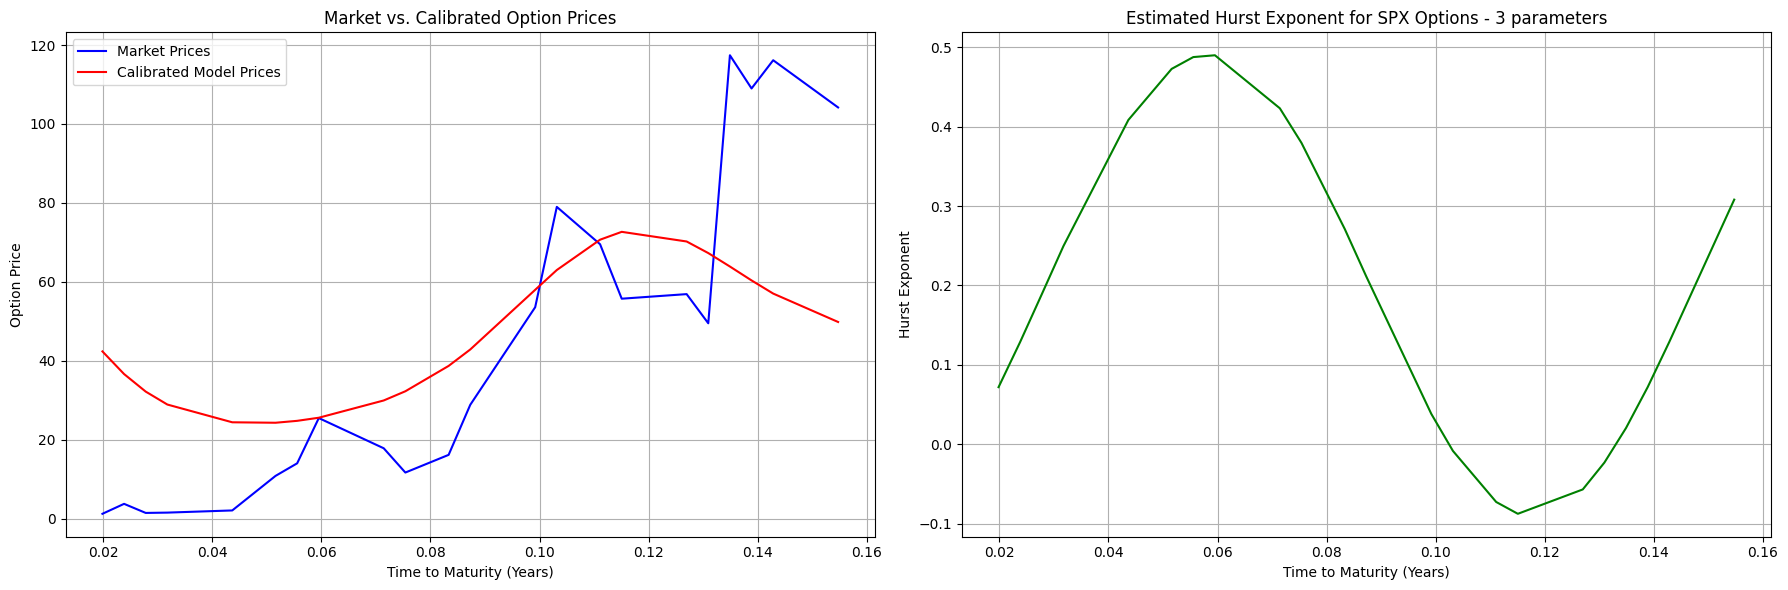

In [116]:
# Calculate option values using the calibrated parameters
calibrated_params = [A_opt, B_opt, C_opt, sigma_opt]

# Calculate option values for each time to maturity in T_values
calculated_option_values = [mBS_call(S0, K, T, r, sigma_opt, calibrated_params[:3]) for T in T_values]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot market prices and calibrated model prices
ax1.plot(T_values, market_prices, label="Market Prices", color='blue')
ax1.plot(T_values, calculated_option_values, label="Calibrated Model Prices", color='red')
ax1.set_xlabel("Time to Maturity (Years)")
ax1.set_ylabel("Option Price")
ax1.set_title("Market vs. Calibrated Option Prices")
ax1.legend()
ax1.grid()

# Plot estimated Hurst exponent
ax2.plot(T_values, [h(T, A_opt, B_opt, C_opt) for T in T_values], color='green')
ax2.set_xlabel("Time to Maturity (Years)")
ax2.set_ylabel("Hurst Exponent")
ax2.set_title("Estimated Hurst Exponent for SPX Options - 3 parameters")
ax2.grid()

plt.tight_layout()
plt.show()

In [117]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.stats import norm  # Import norm for CDF

# Define the Hurst exponent function (sinusoidal)
def h(t, A, B, C, D):
    return A * np.cos(2 * B * (252 / 30) * t + C) + D

# Multifractional Black-Scholes Call price formula
def mBS_call(S0, K, T, r, sigma, H_params):
    A, B, C, D = H_params
    H_T = h(T, A, B, C, D)
    variance = sigma**2 * T**(2 * H_T)
    d1 = (np.log(S0 / K) + r * T + 0.5 * variance) / np.sqrt(variance)
    d2 = d1 - np.sqrt(variance)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Objective function to minimize (sum of squared errors)
def objective(params, S0, K, T_values, r, market_prices):
    A, B, C, D, sigma = params
    H_params = (A, B, C, D)
    model_prices = [mBS_call(S0, K, T, r, sigma, H_params) for T in T_values]
    return np.array(model_prices) - np.array(market_prices)


# Initial parameter guesses (A, B, C, D, sigma)
initial_guess = [0.7, 2 * np.pi, 0.0, 0.1, 0.2]

# Bounds for parameters
bounds = (
    [-1, 0.01, 0, -0.2, 0],  # Lower bounds
    [1, np.inf, np.pi, 0.2, np.inf]  # Upper bounds
)

# Calibrate parameters using least squares
result = least_squares(
    objective,
    initial_guess,
    args=(S0, K, T_values, r, market_prices),
    bounds=bounds
)

# Extract and print estimated parameters
A_opt, B_opt, C_opt, D_opt, sigma_opt = result.x
mse = np.mean(result.fun**2)

print("Calibrated Parameters:")
print(f"A (amplitude): {A_opt:.4f}")
print(f"B (frequency): {B_opt:.4f}")
print(f"C (phase shift): {C_opt:.4f}")
print(f"D (vertical shift): {D_opt:.4f}")
print(f"σ (volatility): {sigma_opt:.4f}")
print(f"MSE: {mse:.4f}")


Calibrated Parameters:
A (amplitude): 0.1729
B (frequency): 8.1063
C (phase shift): 2.4977
D (vertical shift): 0.2000
σ (volatility): 0.0207
MSE: 951.4659


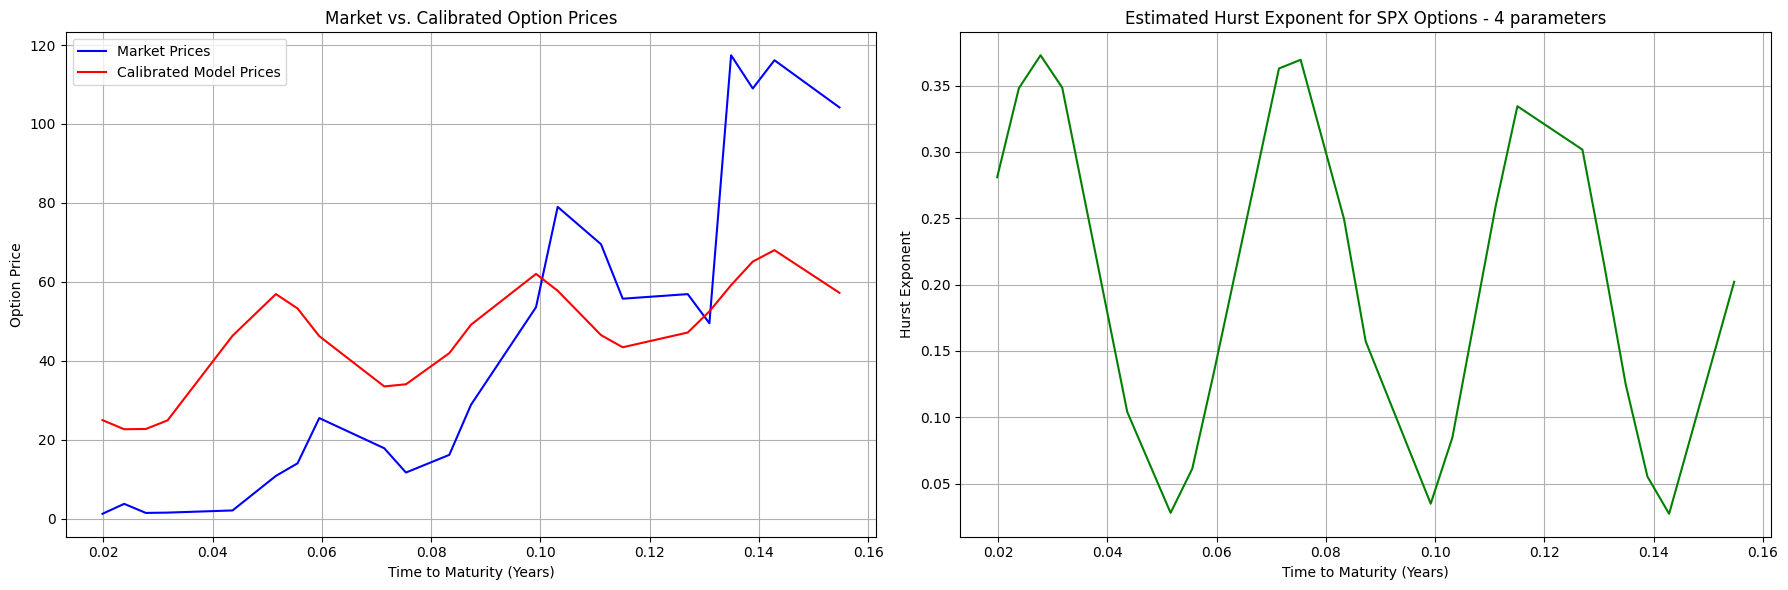

In [118]:

# Calculate option values using the calibrated parameters
calibrated_params = [A_opt, B_opt, C_opt, D_opt, sigma_opt]


# Calculate option values for each time to maturity in T_values
calculated_option_values = [
    mBS_call(S0, K, T, r, sigma_opt, calibrated_params[:4]) for T in T_values
]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot market prices and calibrated model prices
ax1.plot(T_values, market_prices, label="Market Prices", color='blue')
ax1.plot(T_values, calculated_option_values, label="Calibrated Model Prices", color='red')
ax1.set_xlabel("Time to Maturity (Years)")
ax1.set_ylabel("Option Price")
ax1.set_title("Market vs. Calibrated Option Prices")
ax1.legend()
ax1.grid()

# Plot estimated Hurst exponent
ax2.plot(T_values, [h(T, A_opt, B_opt, C_opt, D_opt) for T in T_values], color='green')
ax2.set_xlabel("Time to Maturity (Years)")
ax2.set_ylabel("Hurst Exponent")
ax2.set_title("Estimated Hurst Exponent for SPX Options - 4 parameters")
ax2.grid()

plt.tight_layout()
plt.show()


### Comments

1. Using limited data restricts the model's ability to generalize. The RMSE values reflect the model's performance under a constrained dataset, which may not represent all market conditions.
2. Models like BS_BM_Model and BS_FBM_Model show relatively low RMSEs, as they are simpler and fit well under basic assumptions.
Complex models, such as BS_MBM_Stochastic_H, require larger datasets to estimate parameters like H(t) effectively. Without sufficient data, these models may overfit or underfit, leading to higher RMSEs.